In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import glob
import nibabel as nb
import itertools
import json
import sys
import statsmodels.api as sm
from statsmodels.formula.api import ols, wls
from statsmodels.formula.api import mixedlm
from patsy.contrasts import Treatment

from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.iolib.table import (SimpleTable, default_txt_fmt)
from statsmodels.discrete.discrete_model import Probit, MNLogit
from statsmodels.tools import add_constant
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFdr
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn import metrics
from sklearn.metrics import confusion_matrix

import seaborn as sns
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
np.random.seed(1024)

In [173]:
base_dir = '/home/abhijit/Jyotirmay/my_thesis'
basic_feats = ['age', 'sex', 'bmi_numeric']
spleen_sample_cols = ['0_spleen','1_spleen','2_spleen','3_spleen','4_spleen','5_spleen','6_spleen','7_spleen','8_spleen','9_spleen']
liver_sample_cols = ['0_liver','1_liver','2_liver','3_liver','4_liver','5_liver','6_liver','7_liver','8_liver','9_liver']
vols_feat = ['seg_liver', 'seg_spleen']
iou_feats = ['iou_spleen', 'iou_liver', 'iou_mean']
selected_model_feats = basic_feats + spleen_sample_cols + liver_sample_cols + vols_feat + iou_feats + ['volume_id', 'diabetes_status'] + ['iou_dot_seg_spleen_normalised', 'iou_dot_seg_liver_normalised']
selected_dataset_feats = basic_feats +  ['volume_id', 'diabetes_status'] + vols_feat
all_paths = [
#     {'full_bayesian': './projects/full_bayesian/reports/full_bayesian_KORA_v2/KORA/10_1571866968.4002764_concat_report_final.csv'},
    {'full_bayesian_0dot01': './projects/full_bayesian/reports/full_bayesian_KORA_v4/KORA/10_1572514598.527084_concat_report_final.csv'},
    {'MC_dropout_quicknat': './projects/MC_dropout_quicknat/reports/MC_dropout_quicknat_KORA_v2/KORA/10_1572006141.7793334_concat_report_final.csv'}, 
    {'probabilistic_quicknat': './projects/probabilistic_quicknat/reports/probabilistic_quicknat_KORA_v2/KORA/10_1571996796.7963011_concat_report_final.csv'}, 
    {'hierarchical_quicknat': './projects/hierarchical_quicknat/reports/hierarchical_quicknat_KORA_v2/KORA/10_1571905560.9377904_concat_report_final.csv'},
    {'dataset_KORA_processed': './dataset_groups/whole_body_datasets/KORA/all_processed_True_concat_report_final.csv'},
    {'UKB_MC_dropout_quicknat': './projects/MC_dropout_quicknat/reports/MC_dropout_quicknat_UKB_v2/UKB/0_0.0_concat_report_final.csv'},
    {'UKB_probabilistic_quicknat': './projects/probabilistic_quicknat/reports/probabilistic_quicknat_UKB_v2/UKB/10_1573834823.1121247_concat_report_final.csv'},
    {'UKB_hierarchical_quicknat': './projects/hierarchical_quicknat/reports/hierarchical_quicknat_UKB_v2/UKB/10_1574308007.2486243_concat_report_final.csv'},
    {'dataset_UKB_processed': './dataset_groups/whole_body_datasets/UKB/all_processed_True_concat_report_final.csv'}
]

ukb_paths = [
    {'MC_dropout_quicknat': './projects/MC_dropout_quicknat/reports/MC_dropout_quicknat_UKB_v2/UKB/0_0.0_concat_report_final.csv'},
    {'probabilistic_quicknat': './projects/probabilistic_quicknat/reports/probabilistic_quicknat_UKB_v2/UKB/10_1573834823.1121247_concat_report_final.csv'}
]

model_report_paths = {key:val for d in all_paths for key,val in d.items()}
# ukb_model_report_paths = {key:val for d in ukb_paths for key,val in d.items()}

In [163]:
flatten = lambda l: [item for sublist in l for item in sublist]

def transform_to_categorical(df, categorical_features_list):
    for f in categorical_features_list:
        dfDummies = pd.get_dummies(df[f], prefix = f)
        df = pd.concat([df, dfDummies], axis=1)
    return df

def rename(df, cols_map=None):
    if cols_map is None:
        cols_map =  {'bmi-numeric':'bmi_numeric', 'blood-pressure-diastolic':'blood_pressure_diastolic', 'blood-pressure-systolic':'blood_pressure_systolic',
             'cholesterol-hdl':'cholesterol_hdl', 'cholesterol-ldl':'cholesterol_ldl', 'cholesterol-total':'cholesterol_total',
             'mri-liver-fat-artifacts':'mri_liver_fat_artifacts', 'mri-liver-fat-lobus-dexter':'mri_liver_fat_lobus_dexter', 
              'mri-liver-fat-lobus-sinister':'mri_liver_fat_lobus_sinister', 'mri-liver-fat-portal-vein':'mri_liver_fat_portal_vein',
             'meds-lipoprotein-lowering':'meds_lipoprotein_lowering', 'meds-antihypertensive':'meds_antihypertensive',
              'smoker_non-smoker':'smoker_non_smoker','alcohol-g/day':'alcohol_g_day'}
    df.rename(columns=cols_map, inplace=True)
    return df

def z_score_column_normalise(df, column_list):
    normalised_cols_map = {}
    for column in column_list:
        normalised_cols_map[column] = column+'_normalised'
        df[normalised_cols_map[column]] = (df[column] - df[column].mean())/df[column].std(ddof=0)
    return df, normalised_cols_map

def z_score_group_normalise(df, cols_to_normalise):
    normalised_cols_map = {}
    group_cols_value = df[cols_to_normalise].values
    mean, std = np.mean(group_cols_value), np.std(group_cols_value, ddof=0)
    for column in cols_to_normalise:
        normalised_cols_map[column] = 'normalised_'+column
        df[normalised_cols_map[column]] = (df[column] - mean)/std
    return df, normalised_cols_map

def pre_process_for_mlm(df, to_be_transpose_cols, value_name):
    cols = list(df.columns)
    cols_without_tobe_transposed_cols = list(set(cols) - set(to_be_transpose_cols))
    df = df.melt(id_vars=cols_without_tobe_transposed_cols, 
            value_vars=to_be_transpose_cols, 
            value_name=value_name)

    return df

def model_evaluation_matrics(file_paths_dict, cols_to_fetch):
    dicts = {}
    for model, path in file_paths_dict.items():
        if 'dataset' in model:
            continue
        df = pd.read_csv(path)
        dicts[model] = df[cols_to_fetch].iloc[1:].mean()
    return dicts

def individual_feature_stats(feats, df, target_col, categorical_feats=['diabetes_status', 'sex']):
    p_values = {}
    for f in feats:
        try:
            features_string = make_feature_string([f], categorical_feats)
            fii = ols(f'{target_col} ~ {features_string}', df).fit()
            feat_dict = fii.pvalues.to_dict()
            coeffs = fii.params
        
            for k, v in feat_dict.items():
                orig_key = k
                if k == 'Intercept':
                    k = f+'_Intercept'
                p_values[k] = v

                p_values[k+'_coeff'] = coeffs[orig_key]
            p_values['fitting_score'] = fii.rsquared
        except Exception as e:
            print(e)

    return p_values


def make_feature_string(feats, categorical_cols=[]):
    feat_str = '1+'
    for c_col in categorical_cols:
        if type(c_col) is tuple:
            if c_col[0] not in feats:
#                 print(f'{c_col} is not present in given feature list, SKIPPING IT!')
                continue
            feat_str += f'C({c_col[0]}, Treatment(reference={c_col[1]}))+'
            c_col = c_col[0]
        else:
            if c_col not in feats:
#                 print(f'{c_col} is not present in given feature list, SKIPPING IT!')
                continue
            feat_str += f'C({c_col}, Treatment)+'
        feats.remove(c_col)
    
    other_feats_str = '+'.join(feats)
    if other_feats_str is '':
        final_feat_str = feat_str[:-1]
    else:
        final_feat_str = feat_str + other_feats_str

    return final_feat_str
    



def normal_mixed_effect_model(df, target_col, features_string, group_col, L1_wt=None):
    if L1_wt is None:
        model = mixedlm(f'{target_col} ~ {features_string}', df, groups=df[group_col]).fit()
    else:
        model = mixedlm(f'{target_col} ~ {features_string}', df, groups=df[group_col]).fit_regularized(L1_wt=L1_wt)
    return model

def anova_test(ols_model):
    anova_stats = sm.stats.anova_lm(ols_model)
    return anova_stats

def df_from_nested_dicts(dicts):
    df = pd.concat({k+'_'+kk: pd.concat({kk:pd.DataFrame(vv, index=[0]).T}, axis=1) for k, v in dicts.items() for kk, vv in v.items()}, axis=1)
    return df

def df_from_nested_dicts_group(dicts):
    df = pd.concat({k+'_'+kk: pd.concat({kk:pd.DataFrame(vv, index=[0]).T}, axis=1) for k, v in dicts.items() for kk, vv in v.items()}, axis=1)
    return df

def highlight_significance(df, threshold=0.05):
    return df.style.applymap(lambda x: 'background-color : yellow' if x==True or x<threshold else '')


def discrete_group_feature_stats(feats, df, target_col, categorical_feats=['diabetes_status', 'sex'], is_classification=False):
    p_values = {}
    try:
#             features_string = f'1+C({f}, Treatment)' if f in categorical_feats else f'1+{f}'
        x = df[feats]
        y = df[target_col]
        x = add_constant(x)
        model = Probit(y, x)
        fii = model.fit()
        predicted = fii.predict(x)
#             print(model.pdf(x))
#         fii_ = fii.get_margeff()
#         print(fii.summary())
# #         print(fii_.summary())
        feat_dict = fii.pvalues.to_dict()
        coeffs = fii.params
        
        for k, v in feat_dict.items():
            p_values[k] = v
            p_values[k+'_coeff'] = coeffs[k]

        p_values['aic'] = fii.aic
        p_values['bic'] = fii.bic
        p_values['psuedo_r2'] = fii.prsquared
    except Exception as e:
        print('ERROR:', e)

    return p_values, fii, (y, predicted)

# def weighted_group_feats(df, target_col, features_string, alpha_col):
#     alpha = df[alpha_col].values
#     model = wls(f'{target_col} ~ {features_string}', df, weights=(1/(1-alpha))).fit()
#     return model

def discrete_weighted_group_feats(df, target_col, feats, alpha_col, class_freq=None):
    p_values = {}
    alpha = df[alpha_col].values
    x = df[feats]
    y = df[target_col]
    x = add_constant(x)
    fii = sm.GLM(y, x, family=sm.families.Binomial(sm.families.links.probit), missing='drop', var_weights=1/(1-alpha)).fit()
    predicted = fii.predict(x)
#     print(fii.summary())
#     print(fii.to_dict())
    
    feat_dict = fii.pvalues.to_dict()
    coeffs = fii.params

    for k, v in feat_dict.items():
        p_values[k] = v
        p_values[k+'_coeff'] = coeffs[k]

    p_values['aic'] = fii.aic
    p_values['bic'] = fii.bic
    sst_val = sum(map(lambda x: np.power(x,2),y-np.mean(y))) 
    sse_val = sum(map(lambda x: np.power(x,2),fii.resid_response)) 
    r2 = 1-(sse_val/sst_val)
    p_values['psuedo_r2'] = r2
    return p_values, fii, (y, predicted)

def normal_group_fit(df, target_col, features_string):
    p_values = {}
    fii = ols(f'{target_col} ~ {features_string}', df).fit()
    y = df[target_col].values
    predicted = fii.predict(df)
    feat_dict = fii.pvalues.to_dict()
    coeffs = fii.params

    for k, v in feat_dict.items():
        p_values[k] = v
        p_values[k+'_coeff'] = coeffs[k]

    p_values['aic'] = fii.aic
    p_values['bic'] = fii.bic
    p_values['psuedo_r2'] = fii.rsquared
    return p_values, fii, (y, predicted)

def weighted_group_feats(df, target_col, features_string, alpha_col):
    p_values = {}
    alpha = df[alpha_col].values
    fii = wls(f'{target_col} ~ {features_string}', df, weights=1/(1-alpha)).fit()
    y = df[target_col].values
    predicted = fii.predict(df)
    feat_dict = fii.pvalues.to_dict()
    coeffs = fii.params

    for k, v in feat_dict.items():
        p_values[k] = v
        p_values[k+'_coeff'] = coeffs[k]

    p_values['aic'] = fii.aic
    p_values['bic'] = fii.bic
    p_values['psuedo_r2'] = fii.rsquared
    return p_values, fii, (y, predicted)

In [193]:
def normalise_iou(df):
    for iou_col in ['iou_spleen', 'iou_liver']:
        iou = df[iou_col]
        iou = (iou - iou.min()) / (iou.max() - iou.min())
        df[f'{iou_col}_normalised'] = iou
    df['iou_mean_normalised'] = (df['iou_spleen_normalised'] + df['iou_liver_normalised']) / 2
    return df

# for model, path in model_report_paths.items():
#     if 'dataset' in model:
#         continue
#     print(model)
#     dfk = pd.read_csv(model_report_paths[model])
#     iou = dfk['iou_spleen']
    
#     print(iou.max(), iou.mean(), iou.min(), iou.std())

#     iou.plot.kde()
#     plt.show()
#     iou = (iou - iou.min()) / (iou.max() - iou.min())
#     print(iou.max(), iou.mean(), iou.min(), iou.std())
#     iou.plot.kde()
#     plt.show()
# #     s = np.random.normal(iou.mean(), 10*iou.std(), 1000)
# #     count, bins, ignored = plt.hist(s, 30, density=True)
# #     plt.show()

In [6]:
# sst_val = sum(map(lambda x: np.power(x,2),y-np.mean(y))) 
# sse_val = sum(map(lambda x: np.power(x,2),model.resid_response)) 
# r2 = 1-(sse_val/sst_val)

In [7]:
# r2

In [8]:
# print(logmodel.resid_deviance, logmodel.null_deviance, model.resid_response, logmodel.resid_response)

In [9]:
cols_to_fetch = ['sncc', 'ged', 'iou_spleen', 'iou_liver', 'dice_spleen',
       'dice_liver', 'surface_distance_avg_spleen', 'surface_distance_avg_liver']
dicts = model_evaluation_matrics(model_report_paths, cols_to_fetch)
df_model_eval = pd.DataFrame.from_dict(dicts)
df_model_eval = df_model_eval.T
# df_model_eval.columns = cols_to_fetch
df_model_eval

,sncc,ged,iou_spleen,iou_liver,dice_spleen,dice_liver,surface_distance_avg_spleen,surface_distance_avg_liver
full_bayesian_0dot01,0.440058,0.195726,0.778430,0.843838,0.876213,0.921414,0.878335,0.817338
MC_dropout_quicknat,0.400336,0.166126,0.821658,0.878743,0.897251,0.937764,0.915783,0.871014
probabilistic_quicknat,0.164762,0.228213,0.988126,0.992441,0.873734,0.925382,0.875181,0.827286
hierarchical_quicknat,0.188499,0.209206,0.983803,0.989027,0.883031,0.932817,0.897130,0.854920
UKB_MC_dropout_quicknat,NaN,NaN,0.730973,0.807269,NaN,NaN,NaN,NaN
UKB_probabilistic_quicknat,NaN,NaN,0.965202,0.980590,NaN,NaN,NaN,NaN
UKB_hierarchical_quicknat,NaN,NaN,0.935690,0.939154,NaN,NaN,NaN,NaN


# Post Process reports

In [194]:
dfs = {}
common_vols = None

for model, path in model_report_paths.items():
    if 'dataset' in model:
        continue
    if 'UKB' in model:
        continue
    print(model)
    df = pd.read_csv(path)
    df = rename(df)
    dfs[model] = df
    vols = df[(df['iou_mean']>0.51) & (df['iou_spleen'] != 1.0) & (df['iou_liver'] != 1.0)].volume_id.values
    if common_vols is None:
        common_vols = vols
    else:
        common_vols = np.intersect1d(common_vols, vols)
    print(common_vols.shape)

df_dataset = pd.read_csv(model_report_paths['dataset_KORA_processed'])
df_dataset = rename(df_dataset)
dfs['dataset_KORA_processed']  = df_dataset

for model, df in dfs.items():
    if 'dataset' in model:
        selected_feats = selected_dataset_feats
    else:
        selected_feats = selected_model_feats + ['iou_spleen_normalised', 'iou_liver_normalised', 'iou_mean_normalised']
        df['iou_dot_seg_spleen'] = df['iou_spleen'] * df['seg_spleen']
        df['iou_dot_seg_liver'] = df['iou_liver'] * df['seg_liver']
        df, _ =  z_score_column_normalise(df, ['iou_dot_seg_spleen', 'iou_dot_seg_liver'])
        df = normalise_iou(df)
        
    dfs[model] = df[df.volume_id.isin(common_vols)][selected_feats]
    df, normalised_cols = z_score_column_normalise(dfs[model], ['seg_spleen', 'seg_liver'])
    dfs[model] = df
    print('model shape:', dfs[model].shape)

## Change pre-diabetic state to diabetic
for model, df in dfs.items():
    df.loc[df['diabetes_status']==2, 'diabetes_status'] = 1
    dfs[model] = df
    dfs[model].to_csv(f'final_feats_{model}.csv', index=False)

full_bayesian_0dot01
(148,)
MC_dropout_quicknat
(147,)
probabilistic_quicknat
(147,)
hierarchical_quicknat
(147,)
model shape: (147, 37)
model shape: (147, 37)
model shape: (147, 37)
model shape: (147, 37)
model shape: (147, 9)


In [195]:
dfs_ukb = {}
common_vols = None

for model, path in model_report_paths.items():
    if 'dataset' in model:
        continue
    if 'UKB' not in model:
        continue
    print(model)
    df = pd.read_csv(path)
    df = rename(df)
    dfs_ukb[model] = df
    vols = df[(df['iou_mean']>0.51) & (df['iou_spleen'] != 1.0) & (df['iou_liver'] != 1.0)].volume_id.values
    if common_vols is None:
        common_vols = vols
    else:
        common_vols = np.intersect1d(common_vols, vols)
    print(common_vols.shape)

df_dataset = pd.read_csv(model_report_paths['dataset_UKB_processed'])
# common_vols = np.intersect1d(common_vols, df_dataset.volume_id.values)
df_dataset = rename(df_dataset)
dfs_ukb['dataset_UKB_processed']  = df_dataset

for model, df in dfs_ukb.items():
    if 'dataset' in model:
        selected_feats = selected_dataset_feats
    else:
        selected_feats = selected_model_feats + ['iou_spleen_normalised', 'iou_liver_normalised', 'iou_mean_normalised']
        df['iou_dot_seg_spleen'] = df['iou_spleen'] * df['seg_spleen']
        df['iou_dot_seg_liver'] = df['iou_liver'] * df['seg_liver']
        df, _ =  z_score_column_normalise(df, ['iou_dot_seg_spleen', 'iou_dot_seg_liver'])
        df = normalise_iou(df)
        
    dfs_ukb[model] = df[df.volume_id.isin(common_vols)][selected_feats]
    df, normalised_cols = z_score_column_normalise(dfs_ukb[model], ['seg_spleen', 'seg_liver'])
    dfs_ukb[model] = df
    print('model shape:', dfs_ukb[model].shape)
    
# df_dataset = pd.read_csv(model_report_paths['dataset_KORA_processed'])
# df_dataset = rename(df_dataset)
# dfs['dataset_KORA_processed'] = df[df.volume_id.isin(common_vols)][selected_dataset_feats]
# print(dfs['dataset_KORA_processed'].shape)

## Change pre-diabetic state to diabetic
for model, df in dfs_ukb.items():
    df.loc[df['diabetes_status']==2, 'diabetes_status'] = 1
    dfs_ukb[model] = df
    dfs_ukb[model].to_csv(f'final_feats_{model}.csv', index=False)

UKB_MC_dropout_quicknat
(18201,)
UKB_probabilistic_quicknat
(17328,)
UKB_hierarchical_quicknat
(16574,)
model shape: (16574, 37)
model shape: (16574, 37)
model shape: (16574, 37)
model shape: (6, 9)


# Equations

Eq-1: Diabetes_status = a0 +a1*age + a2*sex + a3*BMI

Eq-2: Diabetes_status = a0 +a1*age + a2*sex + a3*BMI + a4*seg_<spleen|liver>

Eq-3: Diabetes_status = a0 +a1*age + a2*sex + a3*BMI + a4*seg_<spleen|liver> + a5*iou_<spleen|liver>

Eq-4: (Diabetes_status == a0 +a1*age + a2*sex + a3*BMI + a4*seg_<spleen|liver>) * iou_<spleen|liver>

Eq-5: Diabetes_status = a0 +a1*age + a2*sex + a3*BMI +  a4*seg_<spleen|liver>)i

In [160]:
def plot_pdf(good_pdf, bad_pdf, ax):
    ax.fill(x, good_pdf, "g", alpha=0.5)
    ax.fill(x, bad_pdf,"r", alpha=0.5)
    ax.set_xlim([0,1])
    ax.set_ylim([0,5])
    ax.set_title("Probability Distribution", fontsize=14)
    ax.set_ylabel('Counts', fontsize=12)
    ax.set_xlabel('P(X="bad")', fontsize=12)
    ax.legend(["good","bad"])

def auc_roc(y_yp, title):
    y, predicted = y_yp
    y_p = np.where(predicted > 0.5, 1, 0)
    labels = [0, 1]
    y_1_mask = np.where(y==1, True, False)
    y_0_mask = np.where(y==0, True, False)
    xs = [predicted[y_0_mask], predicted[y_1_mask]]

    fig, ax0 = plt.subplots(nrows=1, ncols=1)
    colors = ['red','blue']
    ax0.hist(xs, 10, normed=1, histtype='bar', color=colors, label=labels)
    ax0.legend(prop={'size': 10})
    ax0.set_title('bars with legend')
    plt.show()
    
   
    fpr, tpr, thresholds = metrics.roc_curve(y, predicted, pos_label=1)
    auc_score = metrics.roc_auc_score(y, predicted)
 
    f1_score = metrics.f1_score(y, y_p, labels=labels)
    print(f'{title}: auc_score: {auc_score}, f1_score: {f1_score}')
#     plt.scatter(predicted, y)
#     plt.show()
    plt.plot(fpr, tpr)
    plt.show()
#     print(list(y))
#     print(predicted)
    
#     print(y_p)
    
    cm = confusion_matrix(y, y_p, labels)
    print(cm)
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     cax = ax.matshow(cm)
#     plt.title('Confusion matrix of the classifier')
#     fig.colorbar(cax)
#     ax.set_xticklabels([''] + labels)
#     ax.set_yticklabels([''] + labels)
#     plt.xlabel('Predicted')
#     plt.ylabel('True')
#     plt.show()
    
#     unique_elements, counts_elements = np.unique(predicted, return_counts=True)
#     plt.hist(predicted, bins=20)
#     plt.bar(unique_elements, counts_elements)
#     plt.show()
    
#     print(disp)
#     disp.ax_.set_title(title)

#     print(title)
#     print(disp.confusion_matrix)
#     print(f'{title}:::  fpr: {fpr}, tpr: {tpr}, threshold: {thresholds}')
    return auc_score, f1_score

def regression_plot(y_yp, title=''):
    y, predicted = y_yp
    print(title)
    plt.scatter(predicted, y)
    plt.show()

# Group features (eq 1, eq 2, eq 3 and eq 4)

Optimization terminated successfully.
         Current function value: 0.466512
         Iterations 6


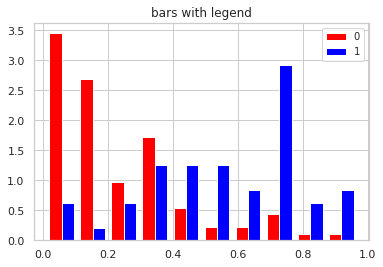

full_bayesian_0dot01_csv_features: auc_score: 0.8463917525773196, f1_score: 0.6888888888888889


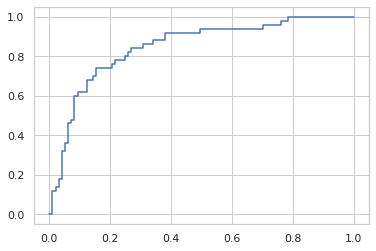

[[88  9]
 [19 31]]
Optimization terminated successfully.
         Current function value: 0.453328
         Iterations 6


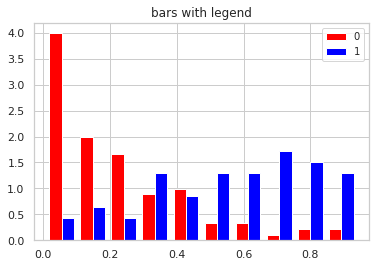

full_bayesian_0dot01_with_seg_volumes: auc_score: 0.8515463917525773, f1_score: 0.6956521739130435


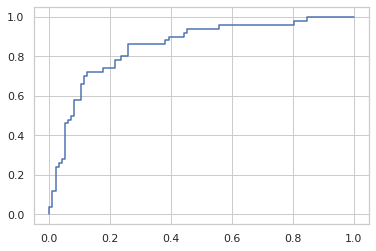

[[87 10]
 [18 32]]
Optimization terminated successfully.
         Current function value: 0.423270
         Iterations 6


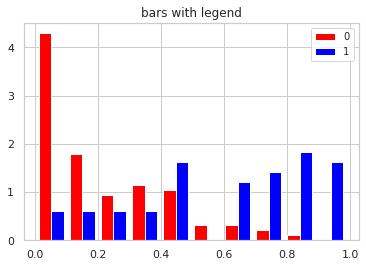

full_bayesian_0dot01_with_seg_iou: auc_score: 0.8682474226804124, f1_score: 0.6741573033707865


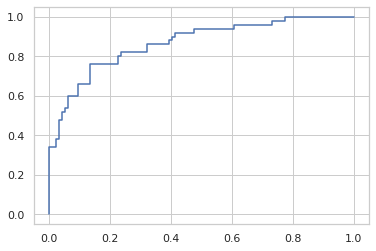

[[88  9]
 [20 30]]
Optimization terminated successfully.
         Current function value: 0.414348
         Iterations 6


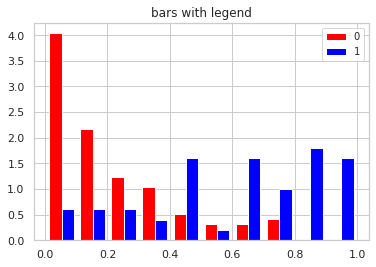

full_bayesian_0dot01_with_seg_dot_iou: auc_score: 0.8715463917525773, f1_score: 0.6813186813186813


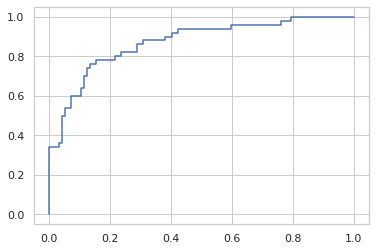

[[87 10]
 [19 31]]


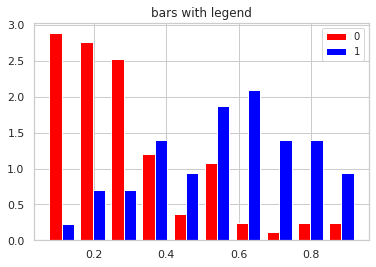

full_bayesian_0dot01_with_seg_reg_iou: auc_score: 0.8325773195876289, f1_score: 0.6666666666666666


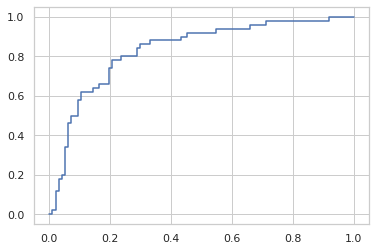

[[81 16]
 [17 33]]
Optimization terminated successfully.
         Current function value: 0.466512
         Iterations 6


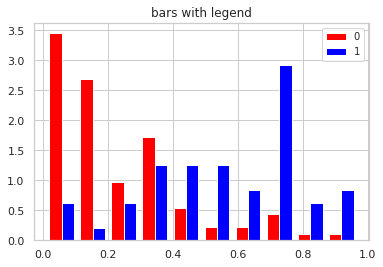

MC_dropout_quicknat_csv_features: auc_score: 0.8463917525773196, f1_score: 0.6888888888888889


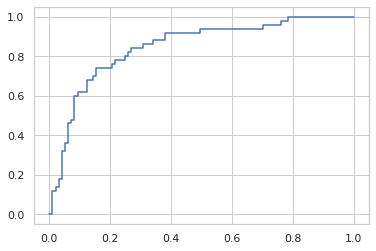

[[88  9]
 [19 31]]
Optimization terminated successfully.
         Current function value: 0.438315
         Iterations 6


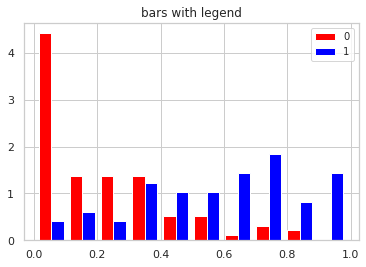

MC_dropout_quicknat_with_seg_volumes: auc_score: 0.86, f1_score: 0.6881720430107526


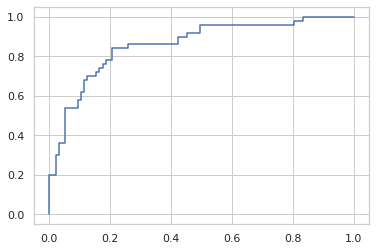

[[86 11]
 [18 32]]
Optimization terminated successfully.
         Current function value: 0.416056
         Iterations 7


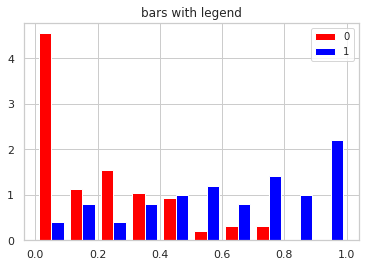

MC_dropout_quicknat_with_seg_iou: auc_score: 0.8665979381443298, f1_score: 0.7391304347826089


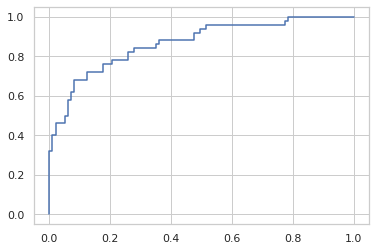

[[89  8]
 [16 34]]
Optimization terminated successfully.
         Current function value: 0.407386
         Iterations 7


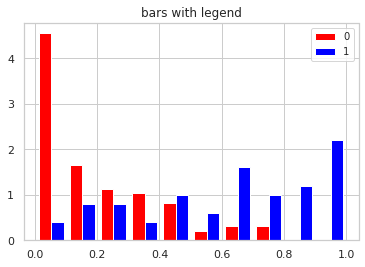

MC_dropout_quicknat_with_seg_dot_iou: auc_score: 0.8696907216494846, f1_score: 0.7391304347826089


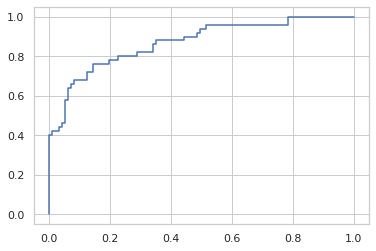

[[89  8]
 [16 34]]


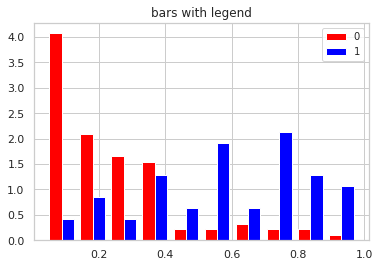

MC_dropout_quicknat_with_seg_reg_iou: auc_score: 0.8562886597938144, f1_score: 0.7096774193548386


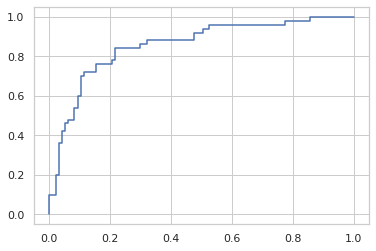

[[87 10]
 [17 33]]
Optimization terminated successfully.
         Current function value: 0.466512
         Iterations 6


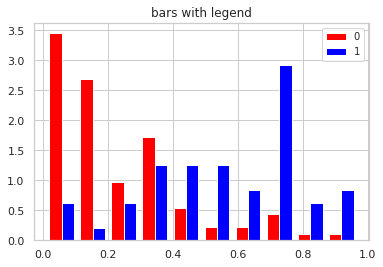

probabilistic_quicknat_csv_features: auc_score: 0.8463917525773196, f1_score: 0.6888888888888889


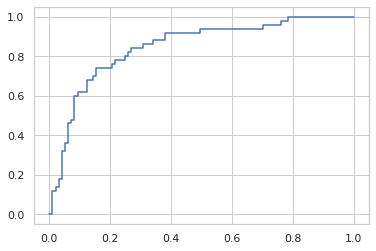

[[88  9]
 [19 31]]
Optimization terminated successfully.
         Current function value: 0.446703
         Iterations 6


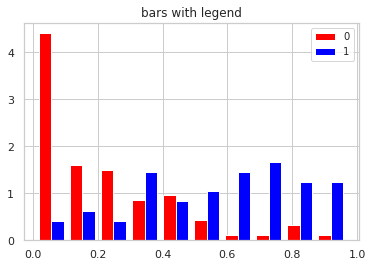

probabilistic_quicknat_with_seg_volumes: auc_score: 0.8560824742268041, f1_score: 0.6813186813186813


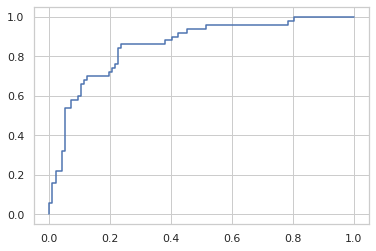

[[87 10]
 [19 31]]
Optimization terminated successfully.
         Current function value: 0.418020
         Iterations 7


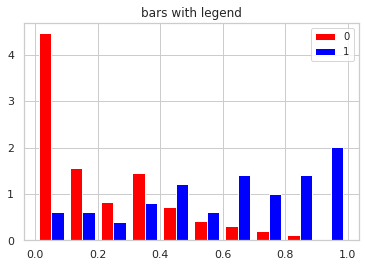

probabilistic_quicknat_with_seg_iou: auc_score: 0.8649484536082473, f1_score: 0.6956521739130435


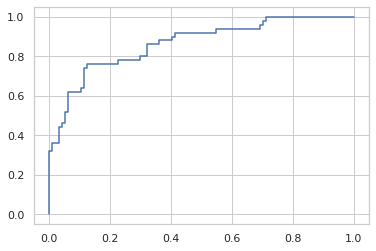

[[87 10]
 [18 32]]
Optimization terminated successfully.
         Current function value: 0.408547
         Iterations 7


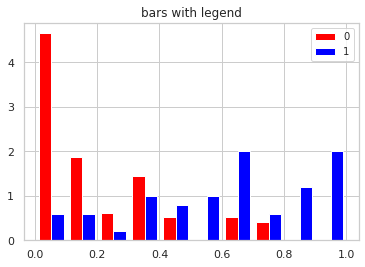

probabilistic_quicknat_with_seg_dot_iou: auc_score: 0.8701030927835053, f1_score: 0.7311827956989247


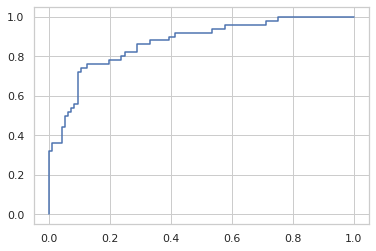

[[88  9]
 [16 34]]


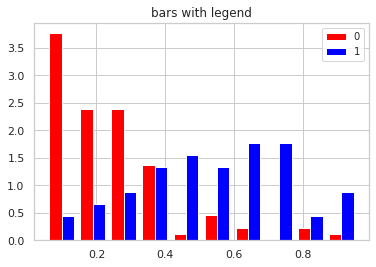

probabilistic_quicknat_with_seg_reg_iou: auc_score: 0.8525773195876288, f1_score: 0.6436781609195402


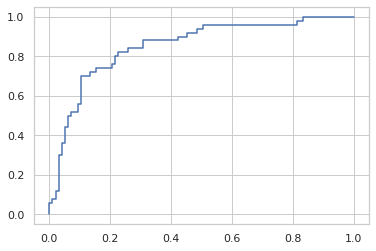

[[88  9]
 [22 28]]
Optimization terminated successfully.
         Current function value: 0.466512
         Iterations 6


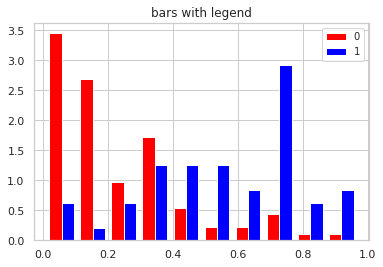

hierarchical_quicknat_csv_features: auc_score: 0.8463917525773196, f1_score: 0.6888888888888889


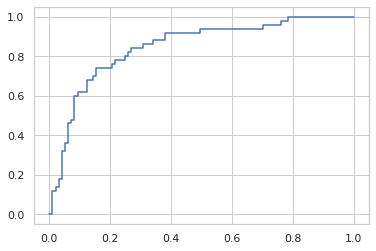

[[88  9]
 [19 31]]
Optimization terminated successfully.
         Current function value: 0.447388
         Iterations 6


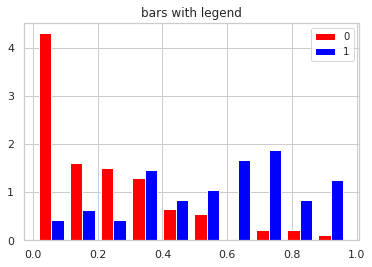

hierarchical_quicknat_with_seg_volumes: auc_score: 0.8579381443298969, f1_score: 0.6956521739130435


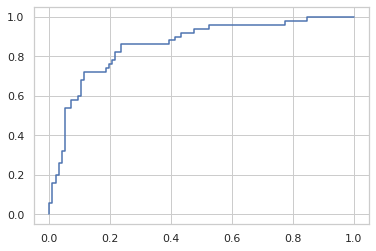

[[87 10]
 [18 32]]
Optimization terminated successfully.
         Current function value: 0.426626
         Iterations 7


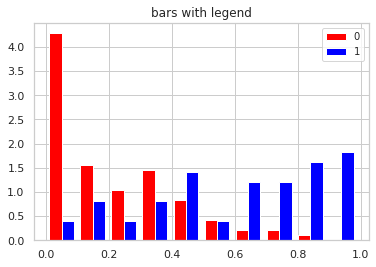

hierarchical_quicknat_with_seg_iou: auc_score: 0.8628865979381443, f1_score: 0.6888888888888889


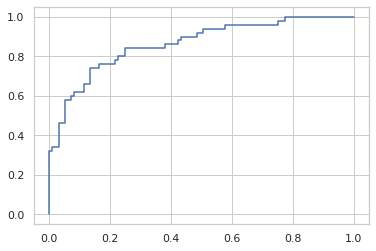

[[88  9]
 [19 31]]
Optimization terminated successfully.
         Current function value: 0.421687
         Iterations 7


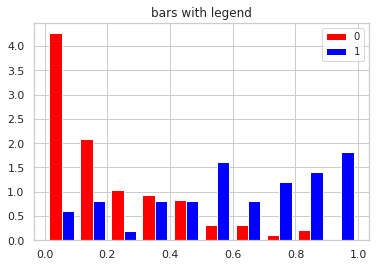

hierarchical_quicknat_with_seg_dot_iou: auc_score: 0.865360824742268, f1_score: 0.7311827956989247


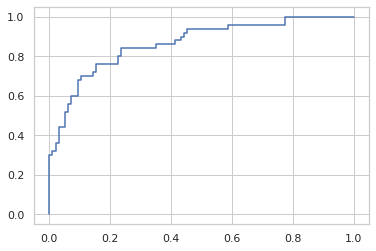

[[88  9]
 [16 34]]


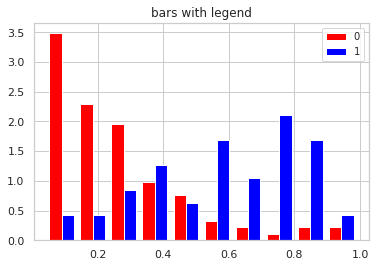

hierarchical_quicknat_with_seg_reg_iou: auc_score: 0.8496907216494846, f1_score: 0.6947368421052631


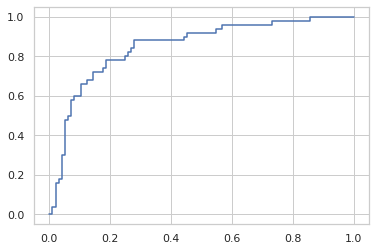

[[85 12]
 [17 33]]
Optimization terminated successfully.
         Current function value: 0.466512
         Iterations 6


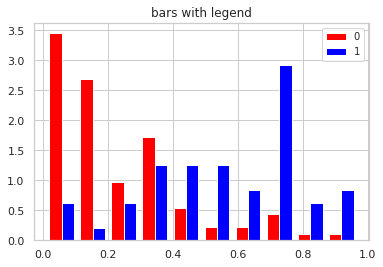

dataset_KORA_processed_csv_features: auc_score: 0.8463917525773196, f1_score: 0.6888888888888889


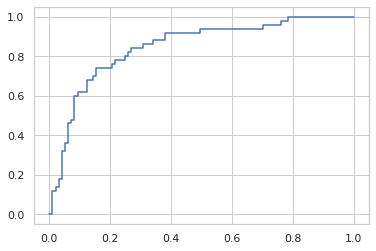

[[88  9]
 [19 31]]
Optimization terminated successfully.
         Current function value: 0.434546
         Iterations 6


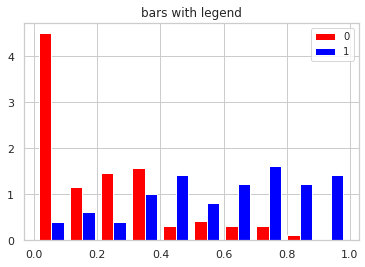

dataset_KORA_processed_with_seg_volumes: auc_score: 0.8604123711340206, f1_score: 0.6739130434782609


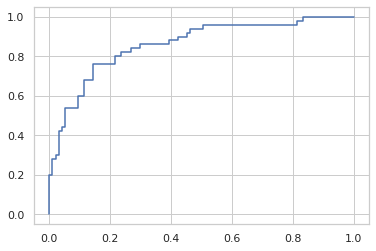

[[86 11]
 [19 31]]


,,,age,age_coeff,aic,auc,bic,bmi_numeric,bmi_numeric_coeff,const,const_coeff,f1,iou_dot_seg_liver_normalised,iou_dot_seg_liver_normalised_coeff,iou_dot_seg_spleen_normalised,iou_dot_seg_spleen_normalised_coeff,iou_liver,iou_liver_coeff,iou_spleen,iou_spleen_coeff,psuedo_r2,seg_liver_normalised,seg_liver_normalised_coeff,seg_spleen_normalised,seg_spleen_normalised_coeff,sex,sex_coeff
full_bayesian_0dot01_diabetes_status,diabetes_status,0,0.000138518,0.0516671,145.154,0.846392,157.116,1.70082e-06,0.124863,1.95267e-10,-7.30687,0.688889,nan,nan,nan,nan,nan,nan,nan,nan,0.272356,nan,nan,nan,nan,0.0147667,0.638647
full_bayesian_0dot01_diabetes_status_with_seg_volumes,diabetes_status_with_seg_volumes,0,6.42342e-05,0.0622271,145.279,0.851546,163.221,0.00216086,0.0993853,2.22206e-09,-7.07477,0.695652,nan,nan,nan,nan,nan,nan,nan,nan,0.292918,0.0553561,0.362874,0.401713,-0.122665,0.123875,0.457745
full_bayesian_0dot01_diabetes_status_with_seg_and_iou,diabetes_status_with_seg_and_iou,0,3.17202e-05,0.0692717,140.441,0.868247,164.365,0.0161631,0.0881832,0.00735714,-6.39484,0.674157,nan,nan,nan,nan,0.0508004,-4.35531,0.0130456,3.72449,0.339802,0.0177676,0.512856,0.162197,-0.223586,0.245023,0.367181
full_bayesian_0dot01_diabetes_status_with_seg_dot_iou,diabetes_status_with_seg_dot_iou,0,2.62113e-05,0.07039,137.818,0.871546,161.742,0.0117955,0.0931973,2.02046e-08,-7.34715,0.681319,0.022047,-1.19667,0.00784248,1.41108,nan,nan,nan,nan,0.353718,0.00565173,1.66338,0.00774393,-1.40364,0.238188,0.367414
full_bayesian_0dot01_diabetes_status_with_regularised_seg_volumes,diabetes_status_with_regularised_seg_volumes,0,3.56677e-52,0.0736938,2253.87,0.832577,1538.22,7.01917e-05,0.0445844,9.55047e-64,-6.63096,0.666667,nan,nan,nan,nan,nan,nan,nan,nan,0.284026,0.00321599,0.188468,0.209278,0.0544423,1.50469e-11,0.692407
MC_dropout_quicknat_diabetes_status,diabetes_status,0,0.000138518,0.0516671,145.154,0.846392,157.116,1.70082e-06,0.124863,1.95267e-10,-7.30687,0.688889,nan,nan,nan,nan,nan,nan,nan,nan,0.272356,nan,nan,nan,nan,0.0147667,0.638647
MC_dropout_quicknat_diabetes_status_with_seg_volumes,diabetes_status_with_seg_volumes,0,4.14119e-05,0.0654854,140.865,0.86,158.807,0.005537,0.0977853,9.64899e-09,-7.17676,0.688172,nan,nan,nan,nan,nan,nan,nan,nan,0.316336,0.0128543,0.528675,0.0863165,-0.249205,0.206989,0.395542
MC_dropout_quicknat_diabetes_status_with_seg_and_iou,diabetes_status_with_seg_and_iou,0,5.58475e-05,0.0669754,138.321,0.866598,162.244,0.00630988,0.102681,0.10392,-6.46544,0.73913,nan,nan,nan,nan,0.262835,-5.14372,0.0304617,4.30446,0.351054,0.0125101,0.566168,0.0267151,-0.354887,0.214105,0.403354
MC_dropout_quicknat_diabetes_status_with_seg_dot_iou,diabetes_status_with_seg_dot_iou,0,6.35655e-05,0.0670587,135.772,0.869691,159.695,0.00436048,0.109343,2.80011e-08,-7.61366,0.73913,0.107802,-1.77367,0.00961285,2.1731,nan,nan,nan,nan,0.364577,0.0398345,2.32275,0.00534521,-2.3362,0.205006,0.413342
MC_dropout_quicknat_diabetes_status_with_regularised_seg_volumes,diabetes_status_with_regularised_seg_volumes,0,2.23278e-57,0.0850152,2111.26,0.856289,1395.61,8.3546e-17,0.0947557,4.3044e-93,-8.77154,0.709677,nan,nan,nan,nan,nan,nan,nan,nan,0.3662,2.37707e-13,0.450462,1.87933e-05,-0.193488,2.18016e-07,0.55619


In [196]:
feats = basic_feats
dicts = {}
anova_test_dicts = {}

for model, df in dfs.items():
#     
#     df, normalised_cols = z_score_column_normalise(df, ['seg_spleen', 'seg_liver'])
#     df = df.fillna(0)

    dicts[model] = {}
    target_col = 'diabetes_status'

#     Equation 1 process
    p_values, statsmodel, y_yp = discrete_group_feature_stats(basic_feats, df, target_col, ['sex'], True)
#     print(y_yp)
    auc_score, f1_score = auc_roc(y_yp, f'{model}_csv_features')
    dicts[model][target_col] = p_values
    dicts[model][target_col]['auc'] = auc_score
    dicts[model][target_col]['f1'] = f1_score
        
#     Equation 2 process
    feats = basic_feats + [ 'seg_spleen_normalised', 'seg_liver_normalised']
    p_values, statsmodel, y_yp = discrete_group_feature_stats(feats, df, target_col, ['sex'], True)
    auc_score, f1_score = auc_roc(y_yp, f'{model}_with_seg_volumes')
    dicts[model][target_col+'_with_seg_volumes'] = p_values
    dicts[model][target_col+'_with_seg_volumes']['auc'] = auc_score
    dicts[model][target_col+'_with_seg_volumes']['f1'] = f1_score
    if 'dataset' in model:
        continue
    
#     Equation 3 process
    feats = basic_feats + [ 'seg_spleen_normalised', 'seg_liver_normalised', 'iou_spleen', 'iou_liver']
    p_values, statsmodel, y_yp = discrete_group_feature_stats(feats, df, target_col, ['sex'], True)
    auc_score, f1_score = auc_roc(y_yp, f'{model}_with_seg_iou')
    dicts[model][target_col+'_with_seg_and_iou'] = p_values
    dicts[model][target_col+'_with_seg_and_iou']['auc'] = auc_score
    dicts[model][target_col+'_with_seg_and_iou']['f1'] = f1_score
    
#     Equation 3.1 process
    feats = basic_feats + [ 'seg_spleen_normalised', 'seg_liver_normalised', 'iou_dot_seg_spleen_normalised', 'iou_dot_seg_liver_normalised']
    p_values, statsmodel, y_yp = discrete_group_feature_stats(feats, df, target_col, ['sex'], True)
    auc_score, f1_score = auc_roc(y_yp, f'{model}_with_seg_dot_iou')
    dicts[model][target_col+'_with_seg_dot_iou'] = p_values
    dicts[model][target_col+'_with_seg_dot_iou']['auc'] = auc_score
    dicts[model][target_col+'_with_seg_dot_iou']['f1'] = f1_score
    
#     Equation 4 process
    feats = basic_feats + [ 'seg_spleen_normalised', 'seg_liver_normalised']
    p_values, statsmodel, y_yp = discrete_weighted_group_feats(df, target_col, feats, 'iou_mean_normalised')
    auc_score, f1_score = auc_roc(y_yp, f'{model}_with_seg_reg_iou')
    dicts[model][target_col+'_with_regularised_seg_volumes'] = p_values
    dicts[model][target_col+'_with_regularised_seg_volumes']['auc'] = auc_score
    dicts[model][target_col+'_with_regularised_seg_volumes']['f1'] = f1_score
    
p_value_df = df_from_nested_dicts(dicts).T
p_value_df_styler = highlight_significance(p_value_df, 0.05)
p_value_df_styler

In [103]:
p_value_df

,,,age,age_coeff,aic,auc,bic,bmi_numeric,bmi_numeric_coeff,const,const_coeff,iou_liver,iou_liver_coeff,iou_spleen,iou_spleen_coeff,psuedo_r2,seg_liver_normalised,seg_liver_normalised_coeff,seg_spleen_normalised,seg_spleen_normalised_coeff,sex,sex_coeff
full_bayesian_0dot01_diabetes_status,diabetes_status,0,1.385176e-04,0.051667,145.154399,NaN,157.116129,1.700820e-06,0.124863,1.952670e-10,-7.306872,NaN,NaN,NaN,NaN,0.272356,NaN,NaN,NaN,NaN,1.476670e-02,0.638647
full_bayesian_0dot01_diabetes_status_with_seg_volumes,diabetes_status_with_seg_volumes,0,6.423421e-05,0.062227,145.278560,NaN,163.221156,2.160859e-03,0.099385,2.222064e-09,-7.074772,NaN,NaN,NaN,NaN,0.292918,5.535610e-02,0.362874,4.017133e-01,-0.122665,1.238746e-01,0.457745
full_bayesian_0dot01_diabetes_status_with_seg_and_iou,diabetes_status_with_seg_and_iou,0,3.172024e-05,0.069272,140.441408,NaN,164.364868,1.616308e-02,0.088183,7.357142e-03,-6.394839,0.050800,-4.355310,0.013046,3.724491,0.339802,1.776762e-02,0.512856,1.621971e-01,-0.223586,2.450233e-01,0.367181
full_bayesian_0dot01_diabetes_status_with_regularised_seg_volumes,diabetes_status_with_regularised_seg_volumes,0,4.862925e-25,0.059334,955.988315,NaN,240.337320,4.599815e-12,0.090806,8.867690e-46,-6.617790,NaN,NaN,NaN,NaN,0.354266,7.633042e-05,0.292980,4.590865e-01,-0.040840,2.432719e-04,0.420219
MC_dropout_quicknat_diabetes_status,diabetes_status,0,1.385176e-04,0.051667,145.154399,NaN,157.116129,1.700820e-06,0.124863,1.952670e-10,-7.306872,NaN,NaN,NaN,NaN,0.272356,NaN,NaN,NaN,NaN,1.476670e-02,0.638647
MC_dropout_quicknat_diabetes_status_with_seg_volumes,diabetes_status_with_seg_volumes,0,4.141190e-05,0.065485,140.864519,NaN,158.807115,5.536996e-03,0.097785,9.648991e-09,-7.176762,NaN,NaN,NaN,NaN,0.316336,1.285432e-02,0.528675,8.631653e-02,-0.249205,2.069889e-01,0.395542
MC_dropout_quicknat_diabetes_status_with_seg_and_iou,diabetes_status_with_seg_and_iou,0,5.584749e-05,0.066975,138.320526,NaN,162.243987,6.309878e-03,0.102681,1.039197e-01,-6.465435,0.262835,-5.143718,0.030462,4.304456,0.351054,1.251011e-02,0.566168,2.671507e-02,-0.354887,2.141045e-01,0.403354
MC_dropout_quicknat_diabetes_status_with_regularised_seg_volumes,diabetes_status_with_regularised_seg_volumes,0,4.797774e-32,0.064775,1097.473530,NaN,381.822535,2.423193e-12,0.086086,2.566874e-52,-6.751309,NaN,NaN,NaN,NaN,0.374495,2.027146e-11,0.481469,9.987423e-04,-0.175877,6.102955e-04,0.375772
probabilistic_quicknat_diabetes_status,diabetes_status,0,1.385176e-04,0.051667,145.154399,NaN,157.116129,1.700820e-06,0.124863,1.952670e-10,-7.306872,NaN,NaN,NaN,NaN,0.272356,NaN,NaN,NaN,NaN,1.476670e-02,0.638647
probabilistic_quicknat_diabetes_status_with_seg_volumes,diabetes_status_with_seg_volumes,0,3.981979e-05,0.063882,143.330682,NaN,161.273278,4.685705e-03,0.091797,7.285718e-09,-6.897968,NaN,NaN,NaN,NaN,0.303252,1.991450e-02,0.457968,3.721231e-01,-0.128712,2.381127e-01,0.360844


# Outputs

A: Base statsmodel comparision with DL statsmodels.

1. (SIMILARITY) Comparision to statsmodel trained on raw dataset, all other statsmodels trained with DL models outputs (segmentation maps), fetures like AGE and BMI show significant relation to DIABETES_STATUS.
2. (DIFFERENCE) Although, SEX has significant relation with DIABETES_STATUS in raw dataset trained statsmodel, but deeplearning outputs based statsmodel does not show the same. 

B: Statsmodel with segmentations output analysis:

1. Full_bayesian does not show any significant relation from segmentations with DIABETES_STATUS
2. MC_dropout and Hierarchical_quicknat shows significant relation from SEG_LIVER_NORMALISED but not from SEG_SPLEEN_NORMALISED with DIABETES_STATUS
3. probabilistic quicknat shows significant relation from SEG_SPLEEN_NORMALISED but nto from SEG_LIVER_NORMALISED with DIABETES_STATUS
4. Considering above result, 2/4 model shows significant relation between SEG_LIVER_NORMALISED (MAJORITY). 

C: Statsmodel with segmentations and iou output analysis.

1. Now with IOU_SPLEEN and IOU_LIVER as inputs features with other feats above, full_bayesian shows significant result from SEG_LIVER_NORMALISED with DIABETES_STATUS
2. With MC_dropout and Hierarchical_quicknat strengthen their significance with DIABETES_STATUS.
3. Probabilistic_quicknat still does not show significance relation between SEG_LIVER_NORMALISED but it strengthen its significance output. 

D: Comparision between statsmodel with and without segmentations and with and without iou_scores.

1. Compare to model without spleen and liver segmentation, model with segmentations are better fit to predict binomial diabetes_status, as per psudo-rsquared values.
2. As per AIC score, all models with segmentation as a feature scored less than model without segmentations as feature, except full_bayesian where it missed slightly.
3. With inclusion of IOU_SCORES features, all model shows better fit as per AIC score now, unlike full_bayesian in point 2.
4. Similarly with the inclusion of IOU_SCORES, psuedo_rsquared value improves by 4% wrt statsmodel with segmentation output only and 7-8% comparision to raw statsmodel.


UKB_MC_dropout_quicknat
Optimization terminated successfully.
         Current function value: 0.182250
         Iterations 7


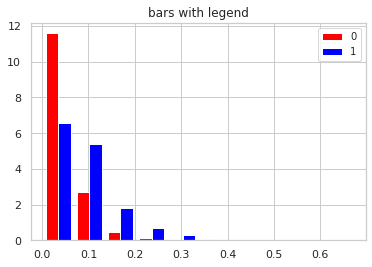

UKB_MC_dropout_quicknat_csv_feats: auc_score: 0.7389245764404656, f1_score: 0.0023752969121140144


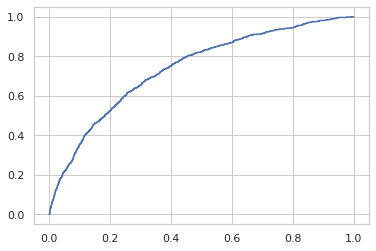

[[15733     1]
 [  839     1]]
Optimization terminated successfully.
         Current function value: 0.181826
         Iterations 7


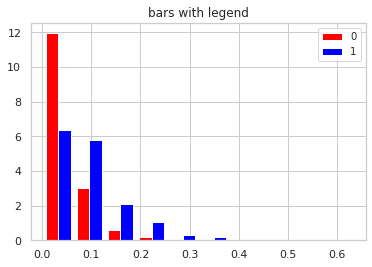

UKB_MC_dropout_quicknat_seg: auc_score: 0.7415443201559256, f1_score: 0.0023752969121140144


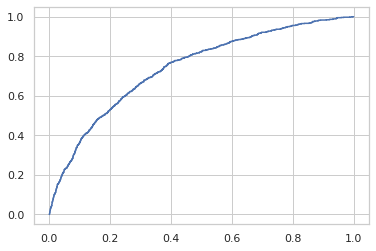

[[15733     1]
 [  839     1]]
Optimization terminated successfully.
         Current function value: 0.181794
         Iterations 7


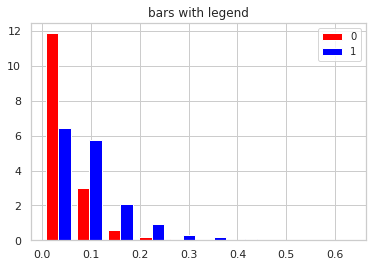

UKB_MC_dropout_quicknat_seg_iou: auc_score: 0.7415527187104662, f1_score: 0.0023752969121140144


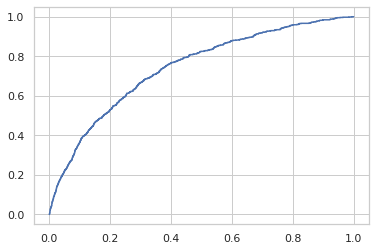

[[15733     1]
 [  839     1]]


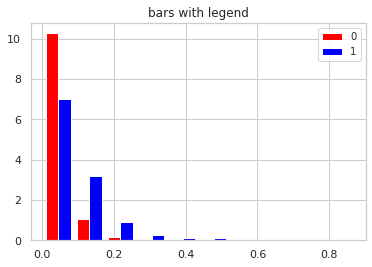

UKB_MC_dropout_quicknat_csv_feats: auc_score: 0.7413489591845381, f1_score: 0.004683840749414521


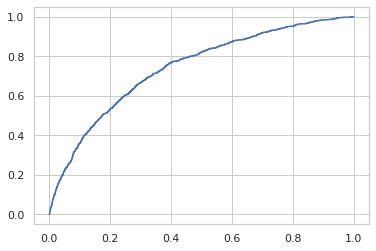

[[15722    12]
 [  838     2]]
UKB_probabilistic_quicknat
Optimization terminated successfully.
         Current function value: 0.182250
         Iterations 7


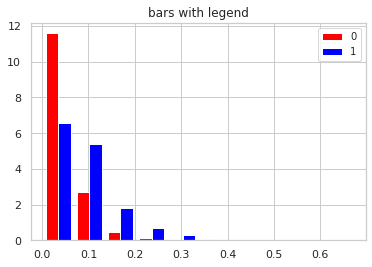

UKB_probabilistic_quicknat_csv_feats: auc_score: 0.7389245764404656, f1_score: 0.0023752969121140144


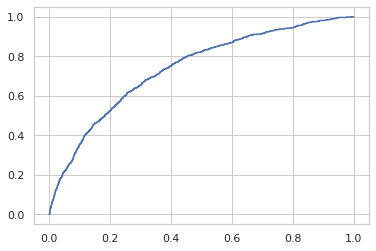

[[15733     1]
 [  839     1]]
Optimization terminated successfully.
         Current function value: 0.182229
         Iterations 7


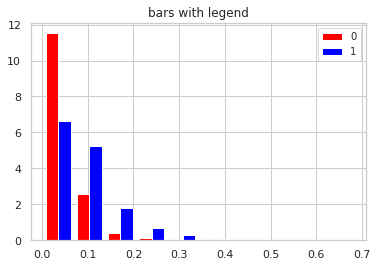

UKB_probabilistic_quicknat_seg: auc_score: 0.739056305120243, f1_score: 0.0023752969121140144


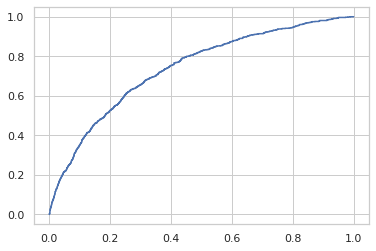

[[15733     1]
 [  839     1]]
Optimization terminated successfully.
         Current function value: 0.182201
         Iterations 7


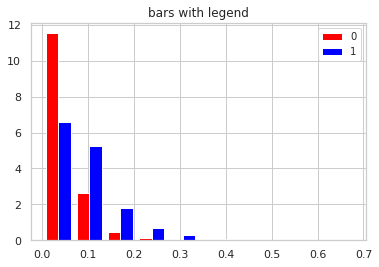

UKB_probabilistic_quicknat_seg_iou: auc_score: 0.7392913133220748, f1_score: 0.0023752969121140144


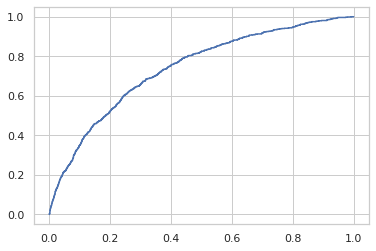

[[15733     1]
 [  839     1]]


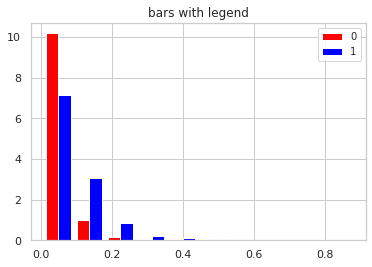

UKB_probabilistic_quicknat_csv_feats: auc_score: 0.7387735537840405, f1_score: 0.004700352526439484


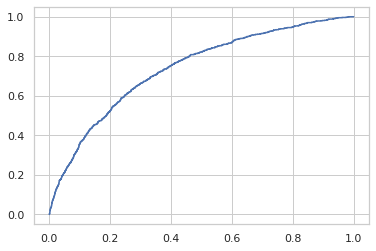

[[15725     9]
 [  838     2]]
UKB_hierarchical_quicknat
Optimization terminated successfully.
         Current function value: 0.182250
         Iterations 7


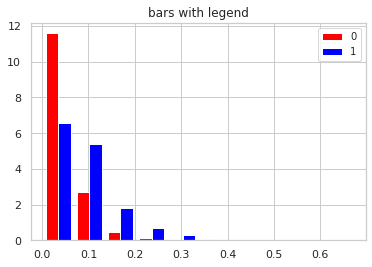

UKB_hierarchical_quicknat_csv_feats: auc_score: 0.7389245764404656, f1_score: 0.0023752969121140144


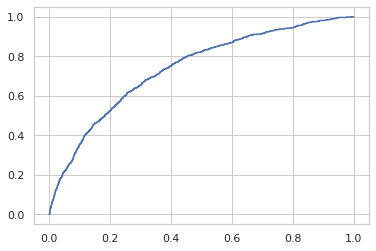

[[15733     1]
 [  839     1]]
Optimization terminated successfully.
         Current function value: 0.182219
         Iterations 7


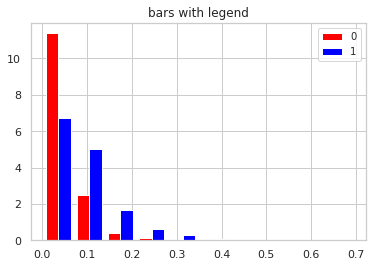

UKB_hierarchical_quicknat_seg: auc_score: 0.7391606439194465, f1_score: 0.0023752969121140144


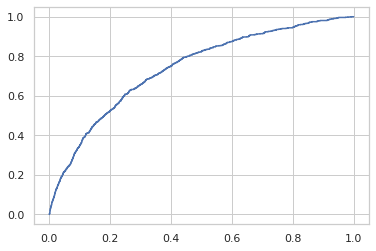

[[15733     1]
 [  839     1]]
Optimization terminated successfully.
         Current function value: 0.182202
         Iterations 7


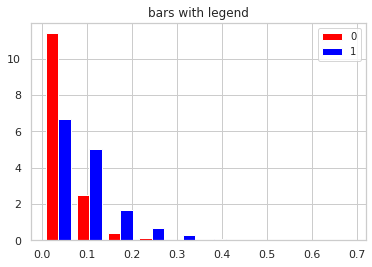

UKB_hierarchical_quicknat_seg_iou: auc_score: 0.7393361056129583, f1_score: 0.0023752969121140144


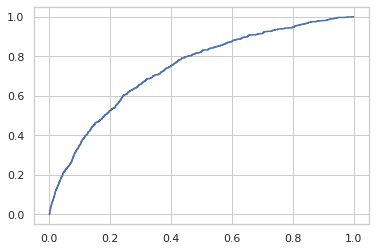

[[15733     1]
 [  839     1]]


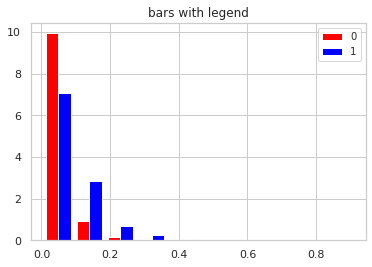

UKB_hierarchical_quicknat_csv_feats: auc_score: 0.7387919398088458, f1_score: 0.004700352526439484


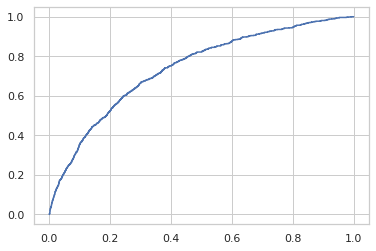

[[15725     9]
 [  838     2]]
dataset_UKB_processed


,,,age,age_coeff,aic,auc,bic,bmi_numeric,bmi_numeric_coeff,const,const_coeff,f1,iou_liver,iou_liver_coeff,iou_spleen,iou_spleen_coeff,psuedo_r2,seg_liver_normalised,seg_liver_normalised_coeff,seg_spleen_normalised,seg_spleen_normalised_coeff,sex,sex_coeff
UKB_MC_dropout_quicknat_diabetes_status,diabetes_status,0,4.37007e-21,0.0226516,6049.22,0.738925,6080.08,2.07431e-94,0.0746599,1.93436e-162,-5.3288,0.0023753,nan,nan,nan,nan,0.0911039,nan,nan,nan,nan,8.11985e-18,0.306386
UKB_MC_dropout_quicknat_diabetes_status_with_seg_volumes,diabetes_status_with_seg_volumes,0,1.29321e-21,0.0230232,6039.16,0.741544,6085.46,1.73188e-89,0.0731803,7.29421e-161,-5.31273,0.0023753,nan,nan,nan,nan,0.0932189,0.000854172,0.0706658,0.560813,-0.0121019,6.0955e-17,0.2991
UKB_MC_dropout_quicknat_diabetes_status_with_seg_and_iou,diabetes_status_with_seg_and_iou,0,1.20072e-21,0.0230513,6042.1,0.741553,6103.83,1.37595e-89,0.0734145,3.44472e-72,-5.55262,0.0023753,0.453354,0.210764,0.641059,0.0819401,0.0933785,0.00104154,0.0702006,0.516972,-0.0141345,5.02752e-17,0.3002
UKB_MC_dropout_quicknat_diabetes_status_seg_reg_iou,diabetes_status_seg_reg_iou,0,4.20188e-100,0.0477832,28957.4,0.741349,-132023,0,0.137855,0,-10.1917,0.00468384,nan,nan,nan,nan,0.0422891,9.53853e-13,0.138585,0.388958,-0.0159394,8.85708e-62,0.554096
UKB_probabilistic_quicknat_diabetes_status,diabetes_status,0,4.37007e-21,0.0226516,6049.22,0.738925,6080.08,2.07431e-94,0.0746599,1.93436e-162,-5.3288,0.0023753,nan,nan,nan,nan,0.0911039,nan,nan,nan,nan,8.11985e-18,0.306386
UKB_probabilistic_quicknat_diabetes_status_with_seg_volumes,diabetes_status_with_seg_volumes,0,3.93653e-21,0.022682,6052.52,0.739056,6098.82,2.11645e-94,0.0746689,1.74097e-162,-5.33135,0.0023753,nan,nan,nan,nan,0.0912089,0.678964,0.0093451,0.771568,0.00656551,7.74879e-18,0.306616
UKB_probabilistic_quicknat_diabetes_status_with_seg_and_iou,diabetes_status_with_seg_and_iou,0,3.99125e-21,0.0226845,6055.6,0.739291,6117.33,2.02297e-94,0.074681,3.81595e-05,-5.38937,0.0023753,0.731994,-0.58027,0.385443,0.64335,0.091347,0.833446,0.0054817,0.922798,0.00224617,8.37888e-18,0.306348
UKB_probabilistic_quicknat_diabetes_status_seg_reg_iou,diabetes_status_seg_reg_iou,0,0,0.0469875,489960,0.738774,328980,0,0.138439,0,-10.1864,0.00470035,nan,nan,nan,nan,0.0413354,1.03113e-08,0.0327735,2.09123e-05,-0.0212416,0,0.628895
UKB_hierarchical_quicknat_diabetes_status,diabetes_status,0,4.37007e-21,0.0226516,6049.22,0.738925,6080.08,2.07431e-94,0.0746599,1.93436e-162,-5.3288,0.0023753,nan,nan,nan,nan,0.0911039,nan,nan,nan,nan,8.11985e-18,0.306386
UKB_hierarchical_quicknat_diabetes_status_with_seg_volumes,diabetes_status_with_seg_volumes,0,3.80437e-21,0.0226909,6052.19,0.739161,6098.48,2.28265e-94,0.0746593,1.65353e-162,-5.33179,0.0023753,nan,nan,nan,nan,0.0912588,0.950241,0.00139545,0.451981,0.0166922,7.5111e-18,0.306755


In [165]:
feats = basic_feats
dicts = {}
anova_test_dicts = {}
for model, df in dfs_ukb.items():
#     
#     df, normalised_cols = z_score_column_normalise(df, ['seg_spleen', 'seg_liver'])
#     df = df.fillna(0)
    print(model)
    if 'UKB' not in model:
#         print('dataset cannot be processed!')
        continue
    if 'dataset' in model:
        continue
        
    dicts[model] = {}
    target_col = 'diabetes_status'

#     Equation 1 process
    p_values, statsmodel, y_yp = discrete_group_feature_stats(basic_feats, df, target_col, ['sex'], True)
    auc_score, f1_score = auc_roc(y_yp, f'{model}_csv_feats')
    dicts[model][target_col] = p_values
    dicts[model][target_col]['auc'] = auc_score
    dicts[model][target_col]['f1'] = f1_score
    
#     Equation 2 process
    feats = basic_feats + [ 'seg_spleen_normalised', 'seg_liver_normalised']
    p_values, statsmodel, y_yp = discrete_group_feature_stats(feats, df, target_col, ['sex'], True)
    auc_score, f1_score = auc_roc(y_yp, f'{model}_seg')
    dicts[model][target_col+'_with_seg_volumes'] = p_values
    dicts[model][target_col+'_with_seg_volumes']['auc'] = auc_score
    dicts[model][target_col+'_with_seg_volumes']['f1'] = f1_score
    
#     Equation 3 process
    feats = basic_feats + [ 'seg_spleen_normalised', 'seg_liver_normalised', 'iou_spleen', 'iou_liver']
    p_values, statsmodel, y_yp = discrete_group_feature_stats(feats, df, target_col, ['sex'], True)
    auc_score, f1_score = auc_roc(y_yp, f'{model}_seg_iou')
    dicts[model][target_col+'_with_seg_and_iou'] = p_values
    dicts[model][target_col+'_with_seg_and_iou']['auc'] = auc_score
    dicts[model][target_col+'_with_seg_and_iou']['f1'] = f1_score
    
    #     Equation 4.0 process
    feats = basic_feats + [ 'seg_spleen_normalised', 'seg_liver_normalised']
    p_values, statsmodel, y_yp = discrete_weighted_group_feats(df, target_col, feats, 'iou_mean', class_freq=[15000, 1000])
    auc_score, f1_score = auc_roc(y_yp, f'{model}_csv_feats')
    dicts[model][target_col+'_seg_reg_iou'] = p_values
    dicts[model][target_col+'_seg_reg_iou']['auc'] = auc_score
    dicts[model][target_col+'_seg_reg_iou']['f1'] = f1_score
# #     Equation 4.1 process
#     feats = basic_feats + [ 'seg_spleen_normalised']
#     p_values, statsmodel = discrete_weighted_group_feats(df, target_col, feats, 'iou_spleen')
#     dicts[model][target_col+'_reg_iou_spleen'] = p_values
    
#     #     Equation 4.2 process
#     feats = basic_feats + [ 'seg_liver_normalised']
#     p_values, statsmodel = discrete_weighted_group_feats(df, target_col, feats, 'iou_liver')
#     dicts[model][target_col+'_reg_iou_liver'] = p_values

p_value_df = df_from_nested_dicts(dicts).T
p_value_df_styler = highlight_significance(p_value_df, 0.05)
p_value_df_styler

# Regularised Group Feats (eq 4)

full_bayesian_0dot01_seg_spleen_normalised_csv-feats


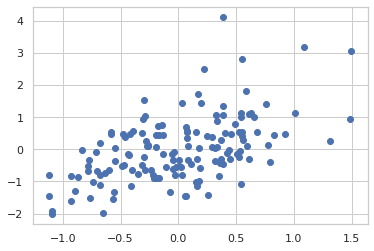

full_bayesian_0dot01_seg_spleen_normalised_seg_iou


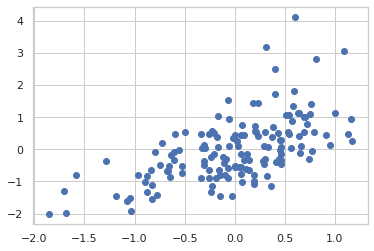

full_bayesian_0dot01_seg_spleen_normalised_seg_reg_iou


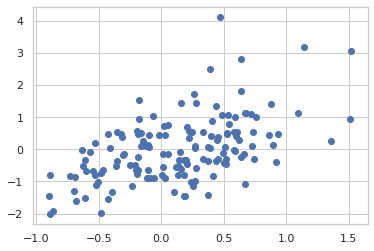

full_bayesian_0dot01_seg_liver_normalised_csv-feats


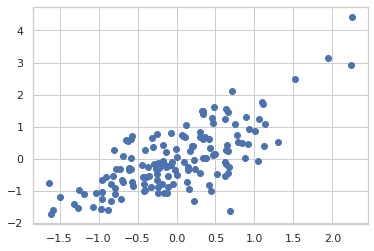

full_bayesian_0dot01_seg_liver_normalised_seg_iou


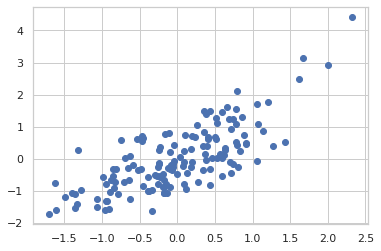

full_bayesian_0dot01_seg_liver_normalised_seg_reg_iou


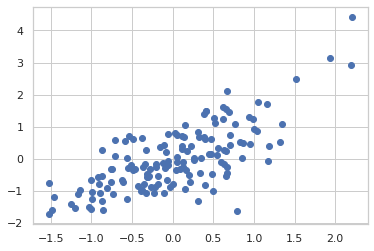

MC_dropout_quicknat_seg_spleen_normalised_csv-feats


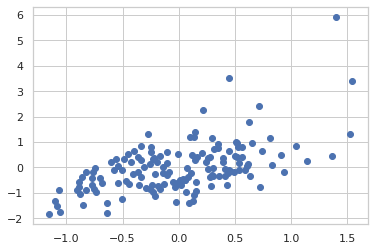

MC_dropout_quicknat_seg_spleen_normalised_seg_iou


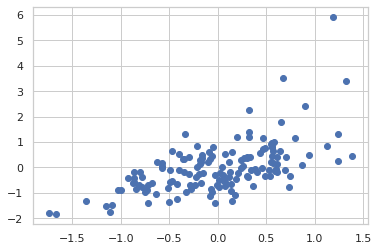

MC_dropout_quicknat_seg_spleen_normalised_seg_reg_iou


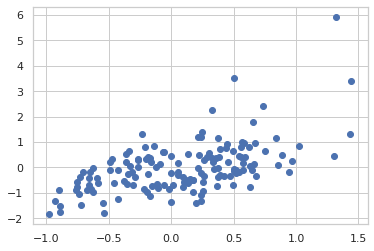

MC_dropout_quicknat_seg_liver_normalised_csv-feats


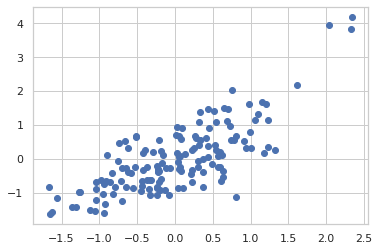

MC_dropout_quicknat_seg_liver_normalised_seg_iou


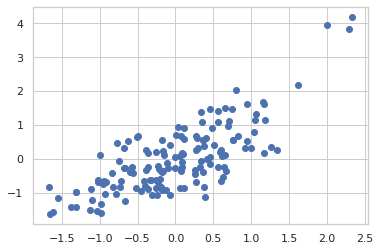

MC_dropout_quicknat_seg_liver_normalised_seg_reg_iou


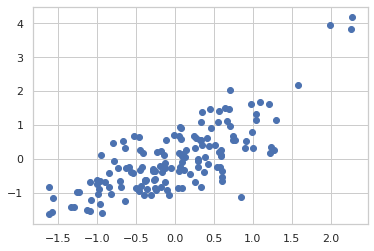

probabilistic_quicknat_seg_spleen_normalised_csv-feats


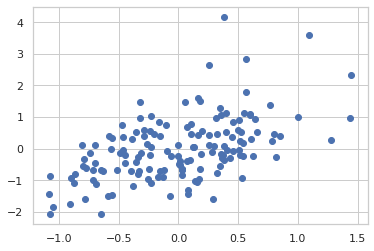

probabilistic_quicknat_seg_spleen_normalised_seg_iou


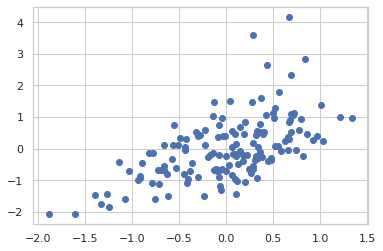

probabilistic_quicknat_seg_spleen_normalised_seg_reg_iou


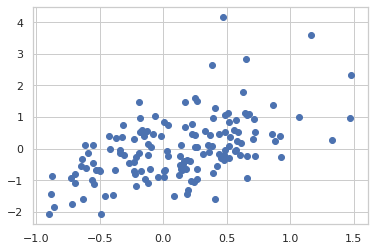

probabilistic_quicknat_seg_liver_normalised_csv-feats


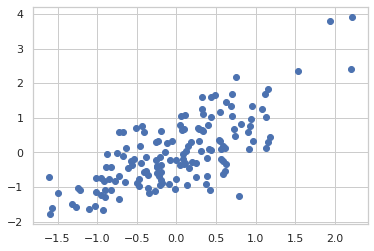

probabilistic_quicknat_seg_liver_normalised_seg_iou


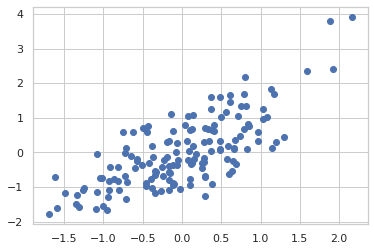

probabilistic_quicknat_seg_liver_normalised_seg_reg_iou


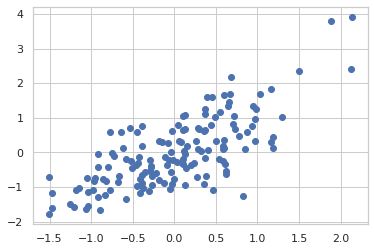

hierarchical_quicknat_seg_spleen_normalised_csv-feats


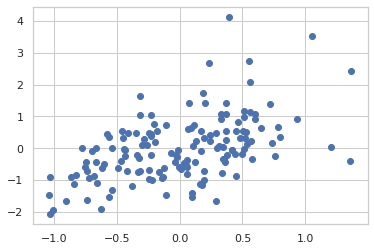

hierarchical_quicknat_seg_spleen_normalised_seg_iou


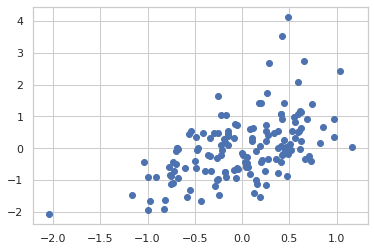

hierarchical_quicknat_seg_spleen_normalised_seg_reg_iou


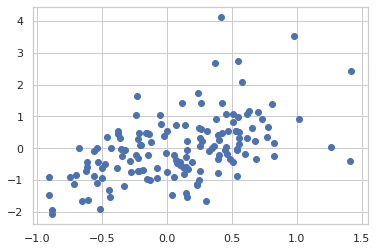

hierarchical_quicknat_seg_liver_normalised_csv-feats


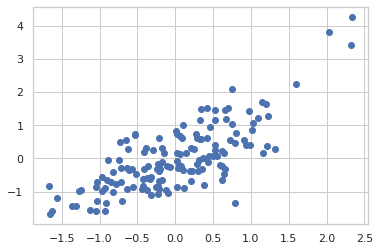

hierarchical_quicknat_seg_liver_normalised_seg_iou


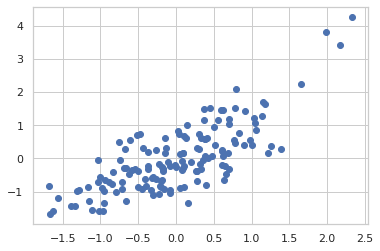

hierarchical_quicknat_seg_liver_normalised_seg_reg_iou


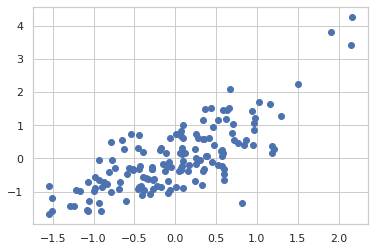

dataset_KORA_processed_seg_spleen_normalised_csv-feats


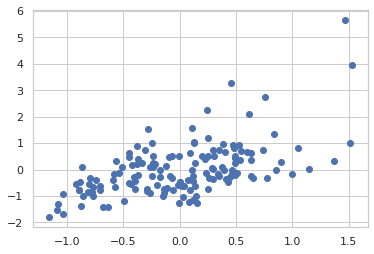

dataset_KORA_processed_seg_liver_normalised_csv-feats


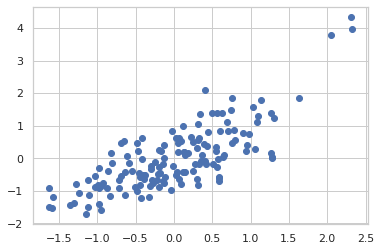

,,,"C(diabetes_status, Treatment)[T.1]","C(diabetes_status, Treatment)[T.1]_coeff","C(sex, Treatment)[T.1]","C(sex, Treatment)[T.1]_coeff",Intercept,Intercept_coeff,age,age_coeff,aic,bic,bmi_numeric,bmi_numeric_coeff,iou_liver,iou_liver_coeff,iou_spleen,iou_spleen_coeff,psuedo_r2
full_bayesian_0dot01_seg_spleen_normalised_with_csv_feats,seg_spleen_normalised_with_csv_feats,0,0.831708,-0.0383389,7.10993e-05,0.616523,0.0629043,-1.2149,0.0133766,-0.020529,377.617,392.57,2.21994e-05,0.0709377,nan,nan,nan,nan,0.286147
full_bayesian_0dot01_seg_spleen_normalised_with_seg_and_iou,seg_spleen_normalised_with_seg_and_iou,0,0.494864,-0.117181,0.000373559,0.525052,3.67396e-05,-3.44017,0.0190193,-0.018416,362.011,379.954,2.5561e-06,0.0750889,nan,nan,4.09161e-05,2.59491,0.366723
full_bayesian_0dot01_seg_spleen_normalised_with_regularised_seg_volumes,seg_spleen_normalised_with_regularised_seg_volumes,0,0.923197,0.0168376,0.000195314,0.579185,0.0954186,-1.12088,0.0414372,-0.0169024,391.141,406.093,0.000275173,0.0652641,nan,nan,nan,nan,0.219665
full_bayesian_0dot01_seg_liver_normalised_with_csv_feats,seg_liver_normalised_with_csv_feats,0,0.053071,0.284528,7.56286e-07,0.631642,0.0669612,-0.969134,8.81387e-08,-0.0374511,315.672,330.624,1.14521e-10,0.0911737,nan,nan,nan,nan,0.531621
full_bayesian_0dot01_seg_liver_normalised_with_seg_and_iou,seg_liver_normalised_with_seg_and_iou,0,0.0206533,0.329724,5.34982e-07,0.617061,0.0001141,-3.2609,2.45802e-08,-0.0377342,305.174,323.117,1.55131e-12,0.0994105,0.000547783,2.43496,nan,nan,0.569796
full_bayesian_0dot01_seg_liver_normalised_with_regularised_seg_volumes,seg_liver_normalised_with_regularised_seg_volumes,0,0.134823,0.196783,5.04771e-09,0.686738,0.00293897,-1.46938,1.64679e-06,-0.0304137,299.008,313.96,5.58953e-12,0.0960761,nan,nan,nan,nan,0.52651
MC_dropout_quicknat_seg_spleen_normalised_with_csv_feats,seg_spleen_normalised_with_csv_feats,0,0.298486,-0.183919,5.04164e-05,0.616466,0.00308023,-1.91012,0.0611889,-0.0151368,371.304,386.256,1.82299e-07,0.0868297,nan,nan,nan,nan,0.316159
MC_dropout_quicknat_seg_spleen_normalised_with_seg_and_iou,seg_spleen_normalised_with_seg_and_iou,0,0.145872,-0.251788,0.000169981,0.556835,1.83463e-05,-4.19876,0.117201,-0.012335,363.121,381.064,1.01471e-07,0.0861253,nan,nan,0.00181038,2.6433,0.361924
MC_dropout_quicknat_seg_spleen_normalised_with_regularised_seg_volumes,seg_spleen_normalised_with_regularised_seg_volumes,0,0.421464,-0.135758,2.02e-05,0.646045,0.0109441,-1.63675,0.111936,-0.0125471,375.275,390.227,1.1248e-05,0.073677,nan,nan,nan,nan,0.262721
MC_dropout_quicknat_seg_liver_normalised_with_csv_feats,seg_liver_normalised_with_csv_feats,0,0.0140865,0.3416,4.40084e-08,0.665189,0.00951843,-1.30003,1.10787e-07,-0.034981,298.141,313.093,9.88919e-13,0.0966927,nan,nan,nan,nan,0.584276


In [61]:
feats = basic_feats
dicts = {}
anova_test_dicts = {}
for model, df in dfs.items():
#     
#     df, normalised_cols = z_score_column_normalise(df, ['seg_spleen', 'seg_liver'])
#     df = df.fillna(0)

        
    dicts[model] = {}
    target_cols = ['seg_spleen_normalised', 'seg_liver_normalised']
    for target_col in target_cols:
#     #     Equation 1 process
#         feats_string = make_feature_string(basic_feats, ['sex', 'diabetes_status'])
#         p_values, statsmodel = normal_group_fit(df, target_col, feats_string)
#         dicts[model][target_col] = p_values

    #     Equation 2 process
        feats = basic_feats + ['diabetes_status']
        feats_string = make_feature_string(feats, ['sex', 'diabetes_status'])
        p_values, statsmodel, y_yp = normal_group_fit(df, target_col, feats_string)
        regression_plot(y_yp, f'{model}_{target_col}_csv-feats')
        dicts[model][target_col+'_with_csv_feats'] = p_values

        if 'dataset' in model:
#             print('dataset cannot be processed!')
            continue
    
    #     Equation 3 process
        if target_col == 'seg_spleen_normalised':
            iou_feat = ['iou_spleen']
        else:
            iou_feat = ['iou_liver']
        feats = basic_feats + [ 'diabetes_status'] + iou_feat
        feats_string = make_feature_string(feats, ['sex', 'diabetes_status'])
        p_values, statsmodel, y_yp = normal_group_fit(df, target_col, feats_string)
        regression_plot(y_yp, f'{model}_{target_col}_seg_iou')
        dicts[model][target_col+'_with_seg_and_iou'] = p_values

    #     Equation 4 process
        feats = basic_feats + [ 'diabetes_status']
        feats_string = make_feature_string(feats, ['sex', 'diabetes_status'])
        p_values, statsmodel, y_yp = weighted_group_feats(df, target_col, feats_string, iou_feat[0])
        regression_plot(y_yp, f'{model}_{target_col}_seg_reg_iou')
        dicts[model][target_col+'_with_regularised_seg_volumes'] = p_values

p_value_df = df_from_nested_dicts(dicts).T
p_value_df.to_csv('to_seg.csv')
p_value_df_styler = highlight_significance(p_value_df, 0.05)
p_value_df_styler

In [22]:
feats = basic_feats
dicts = {}
anova_test_dicts = {}
for model, df in dfs_ukb.items():
#     
#     df, normalised_cols = z_score_column_normalise(df, ['seg_spleen', 'seg_liver'])
#     df = df.fillna(0)


    if 'UKB' not in model:
#         print('dataset cannot be processed!')
        continue
        
    dicts[model] = {}
    target_cols = ['seg_spleen_normalised', 'seg_liver_normalised']
    for target_col in target_cols:
    #     Equation 1 process
        feats = basic_feats + ['diabetes_status']
        feats_string = make_feature_string(feats, ['sex', 'diabetes_status'])
        p_values, statsmodel = normal_group_fit(df, target_col, feats_string)
        dicts[model][target_col] = p_values

#     #     Equation 2 process
#         feats = basic_feats + ['diabetes_status']
#         feats_string = make_feature_string(feats, ['sex', 'diabetes_status'])
#         p_values, statsmodel = normal_group_fit(df, target_col, feats_string)
#         dicts[model][target_col+'_with_seg_volumes'] = p_values

    #     Equation 3 process
        if 'dataset' in model:
            print('dataset cannot be processed!')
            continue
        if target_col == 'seg_spleen_normalised':
            iou_feat = ['iou_spleen']
        else:
            iou_feat = ['iou_liver']
        feats = basic_feats + [ 'diabetes_status'] + iou_feat
        feats_string = make_feature_string(feats, ['sex', 'diabetes_status'])
        p_values, statsmodel = normal_group_fit(df, target_col, feats_string)
        dicts[model][target_col+'_with_iou'] = p_values

    #     Equation 4 process
        feats = basic_feats + [ 'diabetes_status']
        feats_string = make_feature_string(feats, ['sex', 'diabetes_status'])
        p_values, statsmodel = weighted_group_feats(df, target_col, feats_string, iou_feat[0])
        dicts[model][target_col+'_with_regularised_seg_volumes'] = p_values

p_value_df = df_from_nested_dicts(dicts).T
p_value_df.to_csv('to_seg.csv')
p_value_df_styler = highlight_significance(p_value_df, 0.05)
p_value_df_styler

dataset cannot be processed!
dataset cannot be processed!


,,,"C(diabetes_status, Treatment)[T.1.0]","C(diabetes_status, Treatment)[T.1.0]_coeff","C(sex, Treatment)[T.1]","C(sex, Treatment)[T.1]_coeff",Intercept,Intercept_coeff,age,age_coeff,aic,bic,bmi_numeric,bmi_numeric_coeff,iou_liver,iou_liver_coeff,iou_spleen,iou_spleen_coeff,psuedo_r2
UKB_MC_dropout_quicknat_seg_spleen_normalised,seg_spleen_normalised,0,0.0819969,0.0624358,6.12724e-16,0.126632,1.39227e-05,-0.356368,0.00387535,-0.00299675,46843.5,46882.1,5.88869e-23,0.0180205,nan,nan,nan,nan,0.012081
UKB_MC_dropout_quicknat_seg_spleen_normalised_with_iou,seg_spleen_normalised_with_iou,0,0.0937641,0.0578245,3.95655e-13,0.109256,5.7078e-120,-2.18439,0.00119745,-0.00323089,45531,45577.3,5.94743e-24,0.0177212,nan,nan,1.00187e-287,2.53616,0.0874106
UKB_MC_dropout_quicknat_seg_spleen_normalised_with_regularised_seg_volumes,seg_spleen_normalised_with_regularised_seg_volumes,0,0.0630372,0.0687006,6.49973e-17,0.135327,0.00417382,-0.244738,0.00417292,-0.00307664,49192.4,49231,2.89516e-21,0.0181137,nan,nan,nan,nan,0.011889
UKB_MC_dropout_quicknat_seg_liver_normalised,seg_liver_normalised,0,0.000190724,0.133442,1.66271e-09,0.0939826,1.63261e-07,-0.427909,5.03199e-07,-0.00519522,46715,46753.6,2.30962e-47,0.0263478,nan,nan,nan,nan,0.0197102
UKB_MC_dropout_quicknat_seg_liver_normalised_with_iou,seg_liver_normalised_with_iou,0,0.000212547,0.132004,9.34231e-10,0.0950977,3.25219e-31,-1.46955,5.48985e-07,-0.00515996,46600.8,46647.1,1.73173e-48,0.0265823,4.26233e-27,1.27572,nan,nan,0.0265626
UKB_MC_dropout_quicknat_seg_liver_normalised_with_regularised_seg_volumes,seg_liver_normalised_with_regularised_seg_volumes,0,1.49358e-05,0.151358,5.52559e-09,0.0888757,0.000123193,-0.308838,1.90544e-07,-0.00527609,46730.3,46768.8,8.92598e-38,0.0231095,nan,nan,nan,nan,0.0170695
UKB_probabilistic_quicknat_seg_spleen_normalised,seg_spleen_normalised,0,0.566317,0.0207094,0.265079,-0.0175387,0.861134,0.0144287,0.304932,-0.00107073,47040.7,47079.3,0.218223,0.00225925,nan,nan,nan,nan,0.000258704
UKB_probabilistic_quicknat_seg_spleen_normalised_with_iou,seg_spleen_normalised_with_iou,0,0.832901,0.00689013,0.107008,-0.0229393,0,-9.61593,0.238428,-0.00111271,43708.2,43754.5,0.290675,0.00175335,nan,nan,0,9.87741,0.182453
UKB_probabilistic_quicknat_seg_spleen_normalised_with_regularised_seg_volumes,seg_spleen_normalised_with_regularised_seg_volumes,0,0.804754,-0.00853011,0.813642,-0.00356039,6.38452e-07,0.393424,0.0999627,-0.00164594,48593.1,48631.7,0.684221,0.000717777,nan,nan,nan,nan,0.000189233
UKB_probabilistic_quicknat_seg_liver_normalised,seg_liver_normalised,0,0.647572,0.0165083,0.885794,-0.00226034,0.906453,-0.00969307,0.349725,-0.000975991,47041.4,47080,0.145364,0.00267189,nan,nan,nan,nan,0.000212893
